In [ ]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User Upload file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))


!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User Upload file "kaggle.json" with length 73 bytes


In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 98% 659M/675M [00:11<00:00, 85.8MB/s]
100% 675M/675M [00:11<00:00, 63.1MB/s]


In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
path_to_zip_file = "/content/cell-images-for-detecting-malaria.zip"
directory_to_extract_to = "/kaggle/"
import zipfile
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
  zip_ref.extractall(directory_to_extract_to)

In [ ]:
data_path = "/kaggle/cell_images/"

images = []
labels = []

for subfolder in os.listdir(data_path):

    subfolder_path = os.path.join(data_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue

    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)

        labels.append(subfolder)

data = pd.DataFrame({'image': images, 'label': labels})

In [ ]:
data.head()

,image,label
0,/kaggle/cell_images/Parasitized/C70P31_ThinF_I...,Parasitized
1,/kaggle/cell_images/Parasitized/C48P9thinF_IMG...,Parasitized
2,/kaggle/cell_images/Parasitized/C91P52ThinF_IM...,Parasitized
3,/kaggle/cell_images/Parasitized/C131P92ThinF_I...,Parasitized
4,/kaggle/cell_images/Parasitized/C59P20thinF_IM...,Parasitized


In [ ]:
data.shape

(27562, 2)

In [ ]:
strat = data['label']
train_df, dummy_df = train_test_split(data,  train_size= 0.85, shuffle= True, random_state= 123, stratify= strat)

strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (23427, 2)
Validation set shape: (2067, 2)
Test set shape: (2068, 2)


In [ ]:
batch_size = 32
img_size = (150, 150)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='image', y_col='label', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 23424 validated image filenames belonging to 2 classes.
Found 2067 validated image filenames belonging to 2 classes.
Found 2067 validated image filenames belonging to 2 classes.


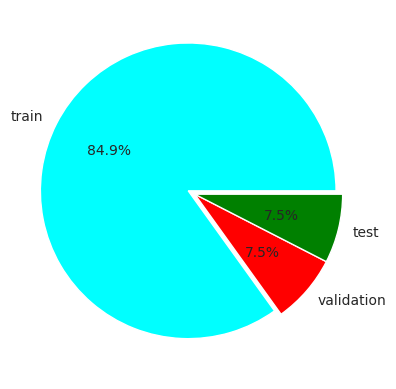

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.pie([len(train_gen), len(valid_gen), len(test_gen)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['aqua', 'red', 'green'], explode=(0.05, 0, 0))
plt.show()
plt.savefig('dataset_pie.png')

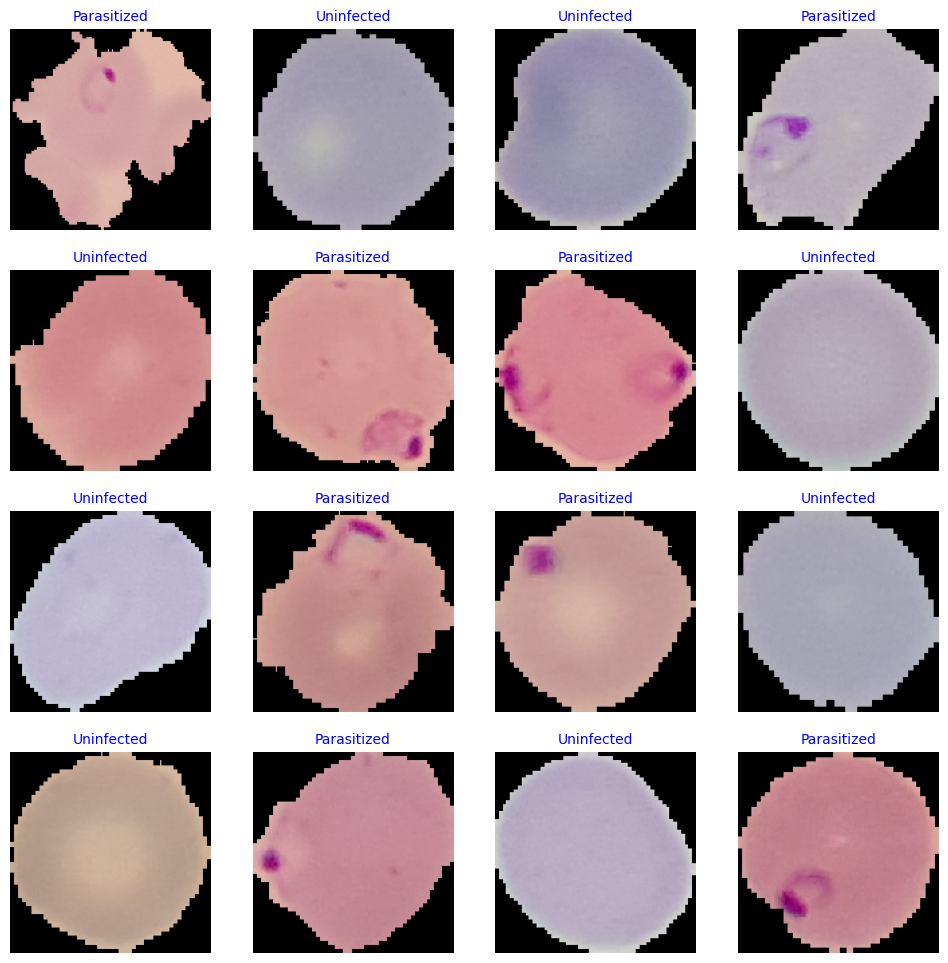

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (12, 12))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 10)
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras import models, layers

n_classes = 2
input_shape = (150, 150, 3)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='Conv1'),
    layers.MaxPooling2D((2, 2), name='MaxPool1'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv2'),
    layers.MaxPooling2D((2, 2), name='MaxPool2'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv3'),
    layers.MaxPooling2D((2, 2), name='MaxPool3'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv4'),
    layers.MaxPooling2D((2, 2), name='MaxPool4'),
    layers.Conv2D(64, (3, 3), activation='relu', name='Conv5'),
    layers.MaxPooling2D((2, 2), name='MaxPool5'),
    layers.Flatten(name='Flatten'),
    layers.Dense(64, activation='relu', name='Dense1'),
    layers.Dense(n_classes, activation='sigmoid', name='Output')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 148, 148, 32)      896       
                                                                 
 MaxPool1 (MaxPooling2D)     (None, 74, 74, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 72, 72, 64)        18496     
                                                                 
 MaxPool2 (MaxPooling2D)     (None, 36, 36, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 34, 34, 64)        36928     
                                                                 
 MaxPool3 (MaxPooling2D)     (None, 17, 17, 64)        0         
                                                                 
 Conv4 (Conv2D)              (None, 15, 15, 64)       

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_gen,
    epochs=2,
    batch_size=32,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[callbacks]
)

Epoch 1/2
732/732 [==============================] - 937s 1s/step - loss: 0.4232 - accuracy: 0.8212 - val_loss: 0.2902 - val_accuracy: 0.8878
Epoch 2/2
732/732 [==============================] - 924s 1s/step - loss: 0.2561 - accuracy: 0.9068 - val_loss: 0.2452 - val_accuracy: 0.9066


In [ ]:
loss, accuracy = model.evaluate(valid_gen)
print("Accuracy score:", accuracy)

65/65 [==============================] - 25s 379ms/step - loss: 0.2452 - accuracy: 0.9066
Accuracy score: 0.9066279530525208
